# Chlorophyll A Data Vis Workbook
### Amy Phung, March 2020

## Setup, Imports, & Globals

### Setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)

# pd.set_option('display.max_rows', 60)
# pd.set_option('display.max_columns', 30)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)

### Imports

In [2]:
%matplotlib inline
import scipy
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import netCDF4
import itertools
import datetime

### Globals

In [3]:
STD_COLUMN_NAMES = ["Src", "Lat", "Long", "Chl-A", "Timestamp", 
                    "Station"]
SAT_COLUMN_NAMES = ["Filename", "Sat Lat", "Sat Long", "Sat Chl-A",
                   "Lat Error", "Long Error", "Time Error"]

## Helper Classes

In [4]:
# Best fit line
class BestFitLine:
    def __init__(self, x, y):
        self.slope, self.intercept, self.r_value, self.p_value, \
            self.std_err = scipy.stats.linregress(x, y)
    
    def computeY(self, x):
        return self.intercept + self.slope*x

## Data Classes

### Main Class

In [5]:
class Dataset:
    """
    Class for datasets with methods to process and reformat raw data
    
    Attributes:
        _source (str): String representing where data came from
        _cols (dict): Dictionary containing lookup for raw column names
        _raw_df (DataFrame): Pandas dataframe containing raw csv data
        df (DataFrame): Pandas dataframe containing formatted data
    """
    def __init__(self, filename, source, column_names):
        self._filename = filename
        self._source = source
        self._cols = column_names
        
    def _loadRaw(self):
        return pd.read_csv(self._filename)
        
    def _processRaw(self):
        pass
    
    def _parseDate(self):
        """ Convert an unformatted timestamp in raw dataset to a Python 
        datetime then to a timestamp. Returns timestamp """
        pass
    
    def _formatData(self):
        self.df["Src"] = self._source
        self.df["Lat"] = self._raw_df[self._cols["Lat"]]
        self.df["Long"] = self._raw_df[self._cols["Long"]]
        self.df["Chl-A"] = self._raw_df[self._cols["Chl-A"]]
        self.df["Timestamp"] = self._raw_df[self._cols["Time"]]
        self.df["Station"] = self._raw_df[self._cols["Station"]]

### BGC Class

In [6]:
class DatasetBGC(Dataset):
    def __init__(self, filename, source, column_names):
        Dataset.__init__(self, filename, source, column_names)
        self._raw_df = self._loadRaw()
        self._processRaw()
        self.df = pd.DataFrame(index=range(0,len(self._raw_df)),
                               columns=STD_COLUMN_NAMES)
        self._formatData()
        
    def _processRaw(self):
        # Remove unused columns
        self._raw_df.dropna(axis=1, how='all', inplace=True) 
        # Drop points missing chlorophyll values
        self._raw_df.dropna(inplace=True) 
        # Drop duplicates (for some reason stations 1-9 like to duplicate)
        self._raw_df.drop_duplicates(inplace=True) 
        # Add in column with station numbers
        self._raw_df["Station Num"] = range(1, len(self._raw_df)+1) 
        # Normalize chlorophyll data
        self._raw_df[self._cols["Chl-A"]] = \
            self._raw_df[self._cols["Chl-A"]]/20. 
        # Add in timestamps
        self._raw_df["Timestamp"] = \
            self._raw_df.apply(self._parseDate, axis=1)
        # Reset dataframe index
        self._raw_df.reset_index(inplace=True)
        
    def _parseDate(self, df_row):
        time_str = df_row["yyyy-mm-ddThh:mm:ss.sss"]
        year   = int(time_str[0:4])
        month  = int(time_str[5:7])
        day    = int(time_str[8:10])
        hour   = int(time_str[11:13])
        minute = int(time_str[14:16])
        second = int(time_str[17:19])
        
        date = datetime.datetime(year, month, day, hour, minute, second)
        timestamp = datetime.datetime.timestamp(date)
        return timestamp

### HC Class

In [7]:
class DatasetHC(Dataset):
    def __init__(self, filename, source, column_names):
        self._best_fit_line = None
        self._cal_df = None
        Dataset.__init__(self, filename, source, column_names)

        self._raw_df = self._loadRaw()
        self._processRaw()
        self.df = pd.DataFrame(index=range(0,len(self._raw_df)),
                               columns=STD_COLUMN_NAMES)
        self._formatData()
        
    def _loadRaw(self):
        """Hydrocast data needs tab delimiter and header skipping"""
        # To get data from ODV:
        # Export>Station Data>ODV Spreadsheet file>Uncheck all exports
        return pd.read_csv(self._filename, delimiter="\t",header=27)
        
    def _processRaw(self):
        # Fill in cruise, station, type, date, lat, long, bottom depth 
        # with most recent values
        col_to_fill = ["Cruise", 
                       "Station",
                       "Type",
                       "yyyy-mm-ddThh:mm:ss.sss",
                       "Longitude [degrees_east]",
                       "Latitude [degrees_north]",
                       "Bot. Depth [m]"]
        
        for col in col_to_fill: self._raw_df[col].fillna(method="pad", 
                                                         inplace=True)
        # Add in column with station numbers as integers
        self._raw_df["Station Num"] = \
            self._raw_df["Station"].apply(self._getStationNum) 
        # Add in column with corrected timestamps
        self._raw_df["Corrected Timestamp"] = \
            self._raw_df["yyyy-mm-ddThh:mm:ss.sss"].apply(self._correctHCTimestamp)
        # Only keep points with valid Chl-A fluorescence measurements
        self._raw_df.dropna(subset=["Chl a Fluorescence [V]"], inplace=True)
        # Compute best fit line for calibrated Chl-A data
        self._best_fit_line, self._cal_df = self._calibrateData()
        # Apply best fit line to full dataset
        self._raw_df["Calculated Chl-A"] = \
            self._raw_df["Chl a Fluorescence [V]"].apply( \
            self._best_fit_line.computeY)
        # Add in timestamps
        self._raw_df["Timestamp"] = \
            self._raw_df.apply(self._parseDate, axis=1)
        # Reset dataframe index
        self._raw_df.reset_index(inplace=True)
    
    def _parseDate(self, df_row):
        time_str = df_row["Corrected Timestamp"]
        year   = int(time_str[0:4])
        month  = int(time_str[5:7])
        day    = int(time_str[8:10])
        hour   = int(time_str[11:13])
        minute = int(time_str[14:16])
        
        date = datetime.datetime(year, month, day, hour, minute)
        timestamp = datetime.datetime.timestamp(date)
        return timestamp
    
    def _formatData(self):
        """Hydrocast data has additional depth column to add to dataset"""
        self.df["Src"] = self._source
        self.df["Lat"] = self._raw_df[self._cols["Lat"]]
        self.df["Long"] = self._raw_df[self._cols["Long"]]
        self.df["Chl-A"] = self._raw_df[self._cols["Chl-A"]]
        self.df["Timestamp"] = self._raw_df[self._cols["Time"]]
        self.df["Station"] = self._raw_df[self._cols["Station"]]
        self.df["Depth"] = self._raw_df["Depth [m]"]
        
    # Other Functions
    def _getStationNum(self, station_name):
        """Parses station name from hydrocast dataset and returns an int 
        representing station number.

        Args:
            station_name (str): Hydrocast station name in the format S290-###-HC

        Returns:
            station_num (int): Hydrocast station number
        """
        return int(station_name[5:8])
    
    def _correctHCTimestamp(self, timestamp):
        """Applies correction to HC timestamp - 2020 is incorrectly written as
        0020, so this function returns a new timestamp in the correct format

        Args:
            timestamp (str): Incorrect timestamp from hydrocast data

        Returns:
            corrected_timestamp (str): Corrected timestamp
        """
        new_timestamp = "2020" + timestamp[4:]
        return new_timestamp
        
    def _calibrateData(self):
        """Computes best fit line between fluorescence and Chl-A value
        for hydrocast data"""
        # Create calibration dataset
        cal_df = self._raw_df.dropna(subset=["Chl-a [ug/L]"])
        # Compute best fit line
        hc_fit_line = BestFitLine(cal_df["Chl a Fluorescence [V]"],
                                  cal_df["Chl-a [ug/L]"])
        return hc_fit_line, cal_df
    
    # Visualizations
    def visualizeCalibration(self):
        plt.scatter(self._cal_df["Chl a Fluorescence [V]"], 
                    self._cal_df["Chl-a [ug/L]"], 
                    c=self._cal_df["Depth [m]"],
                    marker='.')
        plt.colorbar()
        plt.xlabel("Chl a Fluorescence [V]")
        plt.ylabel("Chl-a [ug/L]")
        plt.title("Hydrocast Chl-A Best Fit Calibration Line")

        xp = np.linspace(self._cal_df["Chl a Fluorescence [V]"].min(),
                         self._cal_df["Chl a Fluorescence [V]"].max(),
                         100)
        plt.plot(xp, self._best_fit_line.computeY(xp))

        

### Flow-through Class

In [8]:
class DatasetFT(Dataset):
    """
    Class for flow-through data

    Needs hydrocast data passed in for calibration
    ml_depth = mixed layer depth - determines which hydrocast points can be 
        included in calibration set
    """
    def __init__(self, filename, source, column_names, hc_df, ml_depth=25):
        self._hc_df = hc_df
        self._ml_depth = ml_depth
        self._best_fit_line = None
        self._cal_df = None
        Dataset.__init__(self, filename, source, column_names)
        self._raw_df = self._loadRaw()
        self._processRaw()
        self.df = pd.DataFrame(index=range(0,len(self._raw_df)),
                       columns=STD_COLUMN_NAMES)
        self._formatData()

    def _processRaw(self):
        # Drop points without fluorescence values
        self._raw_df.dropna(subset=["Fluor-Chl-avg-1-min-Value"], inplace=True)
        # Add in column with properly formatted latitude
        self._raw_df["Latitude"] = \
            self._raw_df["GPS-nav-Lat"].apply(self._computeDegreesDecimalFT)
        # Add in column with properly formatted longitude
        self._raw_df["Longitude"] = \
            self._raw_df["GPS-nav-Lon"].apply(self._computeDegreesDecimalFT)
        # Add in timestamps
        self._raw_df["Timestamp"] = \
            self._raw_df.apply(self._parseDate, axis=1)
        # Add in column with station numbers
        self._raw_df["Station Num"] = range(1, len(self._raw_df) + 1)
        # Reset dataframe index
        self._raw_df.reset_index(inplace=True)
        # Compute best fit line
        self._best_fit_line, self._cal_df = self._calibrateData()
        # Apply best fit line to data
        self._raw_df["Calculated Chl-A"] = \
            self._raw_df["Fluor-Chl-avg-1-min-Value"].apply(self._best_fit_line.computeY)
    
    def _parseDate(self, df_row):
        date = df_row["Date"]
        time = df_row["Time"]
        
        year   = int(date[6:10])
        month  = int(date[0:2])
        day    = int(date[3:5])
        hour   = int(time[0:2])
        minute = int(time[3:5])
        second = int(time[6:8])

        date = datetime.datetime(year, month, day, hour, minute, second)
        timestamp = datetime.datetime.timestamp(date)
        return timestamp
    
    # Calibration
    def _calibrateData(self):
        """Computes best fit line between fluorescence and Chl-A value
        for flow-through data"""
        # Initialize empty calibration dataframe
        cal_col = list(self._hc_df.columns) \
                  + ["FT Timestamp", "FT Chlorophyll", "Time Delta"]
        _cal_df = pd.DataFrame(index=range(0,len(self._hc_df)), \
                                    columns=cal_col)
        # Fill in data from hydrocast
        _cal_df.update(self._hc_df)
        # Filter out data outside mixed layer depth
        _cal_df = _cal_df[_cal_df["Depth"] <= self._ml_depth]
        _cal_df.reset_index(inplace=True)
        # Lookup nearest flow-through point
        _cal_df[["FT Timestamp", "FT Chlorophyll", "Time Delta"]] = \
            _cal_df.apply(self._lookupNearestPt, axis=1)
        # Compute best fit line
        ft_fit_line = BestFitLine(_cal_df["FT Chlorophyll"][_cal_df["FT Chlorophyll"]<8].astype(float),
                                  _cal_df["Chl-A"][_cal_df["FT Chlorophyll"]<8].astype(float))
        return ft_fit_line, _cal_df

    def _lookupNearestPt(self, df_row):
        deltas = abs(df_row["Timestamp"] - self._raw_df["Timestamp"])
        nearest_idx = deltas.argmin()
        
        timestamp = self._raw_df["Timestamp"][nearest_idx]
        chl = self._raw_df["Fluor-Chl-avg-1-min-Value"][nearest_idx]
        delta = deltas.min()
        return pd.Series([timestamp, chl, delta])
    
    # Other Functions
    def _computeDegreesDecimalFT(self, gps_val):
        """Converts latitude or longitude value from flow-through dataset
        into a compatible numerical value. 
        Example input values:
            3650.1777S = 36 degrees, 50.1777 minutes South
            4136.8718S = 41 degrees, 36.8718 minutes South
            17446.9143E = 174 degrees, 46.9143 minutes East
            17959.6199W = 179 degrees, 59.6199 minutes West

        Args:
            gps_val (str): Input latitude or longitude value to be converted

        Output:
            gps_num (float): GPS input value in decimal form. Latitude range
                [-90, 90], Longitude range [0, 360]
        """
        dec_idx = gps_val.find(".") 
        degrees = int(gps_val[:dec_idx-2]) # Degrees
        minutes = float(gps_val[dec_idx-2:dec_idx+4]) # Minutes
        decimal = minutes/60.

        gps_num = degrees + decimal

        if gps_val[-1] == "S":
            gps_num = (gps_num*-1) 
        elif gps_val[-1] == "W":
            gps_num = (gps_num*-1) % 360 # Convert from [-180 180] to [0 360]

        return gps_num
    
    # Visualizations
    def visualizeCalibration(self):
        plt.scatter(self._cal_df["FT Chlorophyll"], 
                    self._cal_df["Chl-A"], 
                    c=self._cal_df["Depth"],
                    marker='.')
        
        plt.colorbar()
        plt.xlabel("Flow-Through Chl a Fluorescence [V]")
        plt.ylabel("Hydrocast Chl-a [ug/L]")
        plt.title("Flow-Through Chl-A Best Fit Calibration Line")

        xp = np.linspace(self._cal_df["FT Chlorophyll"].min(),
                         self._cal_df["FT Chlorophyll"].max(),
                         100)
#         plt.plot(xp, self._best_fit_line.computeY(xp))

In [81]:
ft_data._cal_df[ft_data._cal_df["FT Chlorophyll"] > 8]


,index,Src,Lat,Long,Chl-A,Timestamp,Station,Depth,FT Timestamp,FT Chlorophyll,Time Delta
12,5063,HC,-34.977,175.299,0.0733401,1.58295e+09,14,1,1.582951e+09,10.83,4.0


### Satellite Class

In [70]:
class DatasetSat:
    def __init__(self, directory, 
                 csv_dir="data/satellite-data/autogenerated-csv\\",
                 downsample=1000):
        self._directory = directory
        self._csv_dir = csv_dir
        self.downsample = downsample
        self.lookup_df = self._createLookupTable()
        self._active_df = None
            
    def _createLookupTable(self):
        """Creates lookup table for finding appropriate file by time"""
        csv_list = glob.glob('%s/*.csv' % self._csv_dir)
        l_df = pd.DataFrame(columns=["Filename", "Time Start", "Time End"])
        l_df["Filename"] = csv_list
        l_df[["Time Start", "Time End"]] = \
            l_df["Filename"].apply(self._fillTimestamps)
        display(l_df)
        return l_df
            
    def _fillTimestamps(self, f):
        year_st, day_st, year_end, day_end = self._parseFilenameDate(f)
        time_st = datetime.datetime(year_st, 1, 1) \
                  + datetime.timedelta(day_st - 1)
        time_end = datetime.datetime(year_end, 1, 1) \
                  + datetime.timedelta(day_end)
        return pd.Series([time_st.timestamp(), time_end.timestamp()])     
    
    def _loadSatelliteData(self, filename):
        """Loads csv file with satellite data into a dataframe

        Args:
            filename (str): string representing file location of csv 
                file with satellite data
                
        Returns:
            sat_df (DataFrame): pandas dataframe containing satellite data
        """ 
        print("Loading file " + filename + "...")

        # Downsample
        num_lines = sum(1 for l in open(filename)) # count lines
        skip_idx = [x for x in range(1, num_lines) if x % self.downsample != 0]

        sat_df = pd.read_csv(filename, skiprows=skip_idx)

        return sat_df
    
    # Public functions
    def convertSatelliteData(self):
        """Converts all .nc satellite data files in directory to .csv files. 
        First checks if file has already been converted

        Args:
            save_dir (str): directory to save output .csv files
        """
        # Iterate through files in sat_data_dir
        for f in glob.glob('%s/*.nc' % self._directory): 
            if self._checkIfConverted(f, self._csv_dir):
                print(f + " is already converted. Skipping file...")
            else:
                print("Converting " + f + "...")
                self._convertNCtoCSV(f, self._csv_dir)
    
    def findBestFile(self, timestamp):
        """For a given timestamp, finds the best satellite data file"""

        valid_st = self.lookup_df[(timestamp >= self.lookup_df["Time Start"])]
        if len(valid_st) == 0: # Timestamp is earlier than available data
#             print("Warning: Timestamp is earlier than available data. Using first available file")
            return str(self.lookup_df.iloc[0]["Filename"])
        
        valid_end = valid_st[timestamp < valid_st["Time End"]]
        if len(valid_end) == 0: # Timestamp is later than available data
#             print("Warning: Timestamp is later than available data. Using last available file")
            return str(self.lookup_df.iloc[-1]["Filename"])
        
        return str(valid_end.iloc[-1]["Filename"])
    
    def lookupChlorophyll(self, df_row, 
                          lat_col="Lat", long_col = "Long"):
        """Looks up nearest point and returns the corresponding 
        chlorophyll value
        
        Assumes correct satellite data file has already been loaded into 
        the active dataframe.
        
        Args:
            df_row (Series): Pandas series containing row of data with 
                latitude and longitude values to look up
            lat_col (str): String representing column of df_row to use
                for latitude
            long_col (str): String representing column of df_row to use
                for longitude
                
        Returns:
            output (Series): Pandas series containing:
                chl_A_value (float): Chlorophyll value of the nearest 
                    satellite data point to input point
                nearest_lat (float): Latitiude of nearest data point
                nearest_long (float): Longitude of nearest data point
        """
        lat = df_row[lat_col]
        long = df_row[long_col]
        nearest_sat_df = self.findNearestPoint(lat, long, self._active_df)
    
        chl_A_value = nearest_sat_df["Chlorophyll"]
        nearest_lat = nearest_sat_df["Latitude"]
        nearest_long = nearest_sat_df["Longitude"]
    
        output = pd.Series([float(chl_A_value), 
                            float(nearest_lat), 
                            float(nearest_long)])
        print(output)
        return output
        
    def setActiveFrame(self, filename):
        """Loads in csv file specified and sets it as the active dataframe
        """
        self._active_df = self._loadSatelliteData(filename)
        
    # Helper functions for NC to CSV file conversion
    def _checkIfConverted(self, filename, save_dir):
        """Checks to see if .nc file has already been converted to a .csv file

        Args:
            filename (str): string representing file location of satellite data 
                file (.nc format)
            save_dir (str): directory to save output .csv files

        Returns:
            is_converted (bool): whether the corresponding .csv file exists for 
                the input .nc file
        """
        csv_list = glob.glob('%s/*.csv' % save_dir)
        expected_filename = save_dir + filename[filename.find("V"):-3] + ".csv"
        is_converted = expected_filename in csv_list

        return is_converted
    
    def _convertNCtoCSV(self, filename, save_dir):
        """Converts .nc file from satellite data into .csv

        Args:
            filename (str): string representing file location of satellite data 
                file (.nc format)
            save_dir (str): directory to save output .csv file
        """

        nc = netCDF4.Dataset(filename, mode='r')

        lat = nc.variables['lat'][:]
        lon = nc.variables['lon'][:] % 360 # Convert from [-180, 180] to [0, 360]
        chlor_a = nc.variables['chlor_a'][:]

        chl_df = pd.DataFrame(chlor_a.data)

        lat_long = [lat.data, lon.data]
        lat_long_list = list(itertools.product(*lat_long))

        new_df = pd.DataFrame(lat_long_list, columns=["Latitude", "Longitude"])
        new_df["Chlorophyll"] = chl_df.values.flatten()
        # Replace invalid chlorophyll values with NaN
        new_df.replace(-32767.000000, np.nan, inplace=True) 
        # Drop points missing chlorophyll values
        new_df.dropna(inplace=True) 

        new_filename = save_dir + filename[filename.find("V"):-3] + ".csv"
        new_df.to_csv(new_filename)

    def _parseFilenameDate(self, filename):
        """Parses satellite data filename for start and end date

        Args:
            filename (str): string representing filename

        Returns:
            year_st (int): start year of data
            day_st (int): start day of year of data
            year_end (int): end year of data
            day_end (int): end day of year of data
        """
        # Each date starts with V, and add 1 to move cursor over by V
        start_idx = filename.find("V") + 1 
        year_st = filename[start_idx:start_idx + 4] # Year is 4 chars long 
        day_st = filename[start_idx + 4:start_idx + 7] # Day is 3 chars long
        year_end = filename[start_idx + 7:start_idx + 11] 
        day_end = filename[start_idx + 11:start_idx + 14] 

        return int(year_st), int(day_st), int(year_end), int(day_end)
    
    # Helper Functions for chlorophyll lookup
    def findNearestPoint(self, lat, long, df):
        """ Finds approximate nearest point - first searches latitude, 
        then searches longitude

        Doesn't truly find nearest point because that would be more complicated 
        but unneccessary since I'm assuming the data is rather grid-like

        Args:
            lat (float): Latitude of point to find in grid
            long (float): Longitude of point to find in grid
            df (DataFrame): pandas dataframe containing grid of satellite points

        Returns:
            nearest_chl_a (DataFrame): pandas dataframe containing nearest valid 
                satellite station
        """

        lats = df["Latitude"]

        # Compute error for nearest latitude point
        nearest_lat_error = abs(lats-lat).min() 
        # Create bool array where latitude matches
        nearest_lat_idxs = abs(lats-lat) == nearest_lat_error 
        # Use bool array to filter for matching latitude
        lat_sat_df = df[nearest_lat_idxs] 

        # Only look at longitude within matching latitude set
        longs = lat_sat_df["Longitude"] 
        nearest_long_error = abs(longs-long).min()
        nearest_long_idxs = abs(longs-long) == nearest_long_error

        nearest_chl_a = lat_sat_df[nearest_long_idxs]

        return nearest_chl_a
    

In [87]:
# sat_data_dir = "data/satellite-data"
# csv_dir = "data/satellite-data/autogenerated-csv\\"
# sat_data = DatasetSat(sat_data_dir, csv_dir)
# sat_data.convertSatelliteData()
# sat_data.findBestFile(1301353000) # Too early
# sat_data.findBestFile(1499152000) # First
# sat_data.findBestFile(1501353000) # In middle
# sat_data.findBestFile(1701353000) # Too late
dt_object = datetime.datetime.fromtimestamp(1.582951e+09)

print("dt_object =", dt_object)

dt_object = 2020-02-28 20:36:40


## Main Script

In [10]:
bgc_cols = {"Lat": "Latitude [degrees_north]",
            "Long": "Longitude [degrees_east]",
            "Chl-A": "Integral_0 { Chlorophyll-A (original) } * d_Pressure (original) [mg m~^-~^3 * decibar] @ Pressure (original) [decibar]=20.0",
            "Time": "Timestamp",
            "Station": "Station Num"}
bgc_data = DatasetBGC("data/argo-isosurface-data.csv", "BGC", bgc_cols)
bgc_data.df

,Src,Lat,Long,Chl-A,Timestamp,Station
0,BGC,-32.465,185.24200,0.598395,1.501384e+09,1
1,BGC,-32.267,185.30000,0.628195,1.502250e+09,2
2,BGC,-32.298,185.25600,0.415292,1.503110e+09,3
3,BGC,-32.560,185.32600,0.514820,1.503982e+09,4
4,BGC,-32.979,185.25101,0.363909,1.504851e+09,5
...,...,...,...,...,...,...
88,BGC,-42.033,185.93600,0.321619,1.577313e+09,89
89,BGC,-41.869,186.26900,0.333278,1.578173e+09,90
90,BGC,-41.677,186.60600,0.228063,1.579034e+09,91
91,BGC,-41.507,186.82600,0.214175,1.579899e+09,92


1.0545750053408705e-10


,Src,Lat,Long,Chl-A,Timestamp,Station,Depth
0,HC,-36.357,175.172,0.141415,1.582019e+09,1,1.0
1,HC,-36.357,175.172,0.143940,1.582019e+09,1,2.0
2,HC,-36.357,175.172,0.148569,1.582019e+09,1,3.0
3,HC,-36.357,175.172,0.146044,1.582019e+09,1,4.0
4,HC,-36.357,175.172,0.146044,1.582019e+09,1,5.0
...,...,...,...,...,...,...,...
11262,HC,-40.086,178.105,0.427334,1.583859e+09,29,60.0
11263,HC,-40.086,178.105,0.196705,1.583859e+09,29,99.0
11264,HC,-40.086,178.105,0.095367,1.583859e+09,29,199.0
11265,HC,-40.086,178.105,0.094504,1.583859e+09,29,297.0


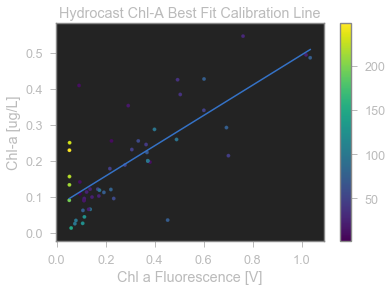

In [11]:
hc_cols = {"Lat": "Latitude [degrees_north]",
           "Long": "Longitude [degrees_east]",
           "Time": "Timestamp",
           "Chl-A": "Calculated Chl-A",
           "Station": "Station Num"}
hc_data = DatasetHC("data/data_from_S290-CTD-HC-2.txt", "HC", hc_cols)
print(hc_data._best_fit_line.p_value)
hc_data.visualizeCalibration()
hc_data.df

In [112]:
# hc_data._cal_df

3.6878867343851195e-05


,Src,Lat,Long,Chl-A,Timestamp,Station
0,FT,-36.772600,174.957650,0.392385,1.582000e+09,1
1,FT,-36.771450,174.958717,0.455875,1.582000e+09,2
2,FT,-36.770367,174.959917,0.462322,1.582000e+09,3
3,FT,-36.769350,174.961100,0.446889,1.582000e+09,4
4,FT,-36.768417,174.962550,0.443568,1.582000e+09,5
...,...,...,...,...,...,...
32941,FT,-41.614883,176.169533,0.249582,1.583989e+09,32942
32942,FT,-41.614867,176.167717,0.250949,1.583989e+09,32943
32943,FT,-41.615383,176.166083,0.252121,1.583989e+09,32944
32944,FT,-41.615500,176.164250,0.253098,1.583989e+09,32945


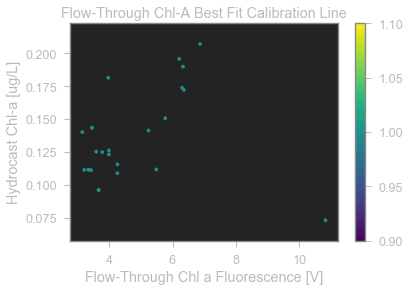

In [12]:
ft_cols = {"Lat": "Latitude",
            "Long": "Longitude",
            "Chl-A": "Calculated Chl-A",
            "Time": "Timestamp",
            "Station": "Station Num"}
ft_data = DatasetFT("data/Event60sec_003.elg", "FT", ft_cols, hc_data.df, ml_depth=1)

# display(ft_data._raw_df)
# display(ft_data._cal_df)
print(ft_data._best_fit_line.p_value)
ft_data.visualizeCalibration()
display(ft_data.df)

In [18]:
# measurements = np.array(ft_data.df["Chl-A"])
measurements = np.array(ft_data._cal_df["FT Chlorophyll"])

print(len(measurements))
mean = np.mean(measurements, axis=0)
sd = np.std(measurements, axis=0)

final_list = [x for x in measurements if (x > mean - 3 * sd)]
final_list = [x for x in final_list if (x < mean + 3 * sd)]
len(final_list)

25


24

In [22]:
# Merge datasets
frames = [bgc_data.df, ft_data.df]
compiled_df = pd.concat(frames, ignore_index=True)
compiled_df

,Src,Lat,Long,Chl-A,Timestamp,Station
0,BGC,-32.465000,185.242000,0.598395,1.501384e+09,1
1,BGC,-32.267000,185.300000,0.628195,1.502250e+09,2
2,BGC,-32.298000,185.256000,0.415292,1.503110e+09,3
3,BGC,-32.560000,185.326000,0.514820,1.503982e+09,4
4,BGC,-32.979000,185.251010,0.363909,1.504851e+09,5
...,...,...,...,...,...,...
33034,FT,-41.614883,176.169533,0.249582,1.583989e+09,32942
33035,FT,-41.614867,176.167717,0.250949,1.583989e+09,32943
33036,FT,-41.615383,176.166083,0.252121,1.583989e+09,32944
33037,FT,-41.615500,176.164250,0.253098,1.583989e+09,32945


In [71]:
sat_data_dir = "data/satellite-data"
csv_dir = "data/satellite-data/autogenerated-csv\\"
sat_data = DatasetSat(sat_data_dir, csv_dir, downsample=1000)

,Filename,Time Start,Time End
0,data/satellite-data/autogenerated-csv\V2017185...,1.499152e+09,1.499843e+09
1,data/satellite-data/autogenerated-csv\V2017193...,1.499843e+09,1.500534e+09
2,data/satellite-data/autogenerated-csv\V2017201...,1.500534e+09,1.501225e+09
3,data/satellite-data/autogenerated-csv\V2017209...,1.501225e+09,1.501916e+09
4,data/satellite-data/autogenerated-csv\V2017217...,1.501916e+09,1.502608e+09
...,...,...,...
117,data/satellite-data/autogenerated-csv\V2020017...,1.579248e+09,1.579939e+09
118,data/satellite-data/autogenerated-csv\V2020025...,1.579939e+09,1.580630e+09
119,data/satellite-data/autogenerated-csv\V2020033...,1.580630e+09,1.581322e+09
120,data/satellite-data/autogenerated-csv\V2020041...,1.581322e+09,1.582013e+09


In [78]:
import timeit

start_time = timeit.default_timer()

# Look up best satellite data file for each point
# compiled_df["Sat File"] = compiled_df["Timestamp"].apply(sat_data.findBestFile)

elapsed = timeit.default_timer() - start_time
print("Time for file lookup: " + str(elapsed))

i = 0
tot = float(len(compiled_df["Sat File"].unique()))

start_time_overall = timeit.default_timer()

# Load satellite data files individually 
for filename in compiled_df["Sat File"].unique():
    i = i + 1
    print(str(i/tot * 100) + "% Complete" )
    start_time = timeit.default_timer()
    
    # Set active frame
    sat_data.setActiveFrame(filename)
        
    # Look up chlorophyll values for matching files
    mask = compiled_df["Sat File"] == filename
    compiled_df.loc[mask, ["Sat Chl-A", "Sat Lat", "Sat Long"]] = [1,2,3]#pd.Series([4,2,3])#\
        #compiled_df.loc[mask].apply(sat_data.lookupChlorophyll, axis=1)
    display(compiled_df.loc[mask])
    display(compiled_df.loc[mask, ["Sat Chl-A", "Sat Lat", "Sat Long"]])
    
    elapsed = timeit.default_timer() - start_time
    print("Loop time: " + str(elapsed))
    if i == 3:
        break

elapsed_overall = timeit.default_timer() - start_time_overall
print("Time for full execution: " + str(elapsed_overall))

Time for file lookup: 3.103027120232582e-05
1.0526315789473684% Complete
Loading file data/satellite-data/autogenerated-csv\V20172092017216.L3m_8D_SNPP_CHL.x_chlor_a.csv...


,Src,Lat,Long,Chl-A,Timestamp,Station,Sat File,Sat Chl-A,Sat Lat,Sat Long
0,BGC,-32.465,185.242,0.598395,1.501384e+09,1,data/satellite-data/autogenerated-csv\V2017209...,1.0,2.0,3.0


,Sat Chl-A,Sat Lat,Sat Long
0,1.0,2.0,3.0


Loop time: 4.117241196923715
2.1052631578947367% Complete
Loading file data/satellite-data/autogenerated-csv\V20172172017224.L3m_8D_SNPP_CHL.x_chlor_a.csv...


,Src,Lat,Long,Chl-A,Timestamp,Station,Sat File,Sat Chl-A,Sat Lat,Sat Long
1,BGC,-32.267,185.3,0.628195,1.502250e+09,2,data/satellite-data/autogenerated-csv\V2017217...,1.0,2.0,3.0


,Sat Chl-A,Sat Lat,Sat Long
1,1.0,2.0,3.0


Loop time: 4.227885286709352
3.1578947368421053% Complete
Loading file data/satellite-data/autogenerated-csv\V20172252017232.L3m_8D_SNPP_CHL.x_chlor_a.csv...


,Src,Lat,Long,Chl-A,Timestamp,Station,Sat File,Sat Chl-A,Sat Lat,Sat Long
2,BGC,-32.298,185.256,0.415292,1.503110e+09,3,data/satellite-data/autogenerated-csv\V2017225...,1.0,2.0,3.0


,Sat Chl-A,Sat Lat,Sat Long
2,1.0,2.0,3.0


Loop time: 4.481664985854877
Time for full execution: 12.833800785629137


In [73]:
compiled_df[compiled_df["Sat File"]=="data/satellite-data/autogenerated-csv\V20172252017232.L3m_8D_SNPP_CHL.x_chlor_a.csv"]

,Src,Lat,Long,Chl-A,Timestamp,Station,Sat File,Sat Chl-A,Sat Lat,Sat Long
2,BGC,-32.298,185.256,0.415292,1.503110e+09,3,data/satellite-data/autogenerated-csv\V2017225...,NaN,NaN,NaN


In [79]:
compiled_df

,Src,Lat,Long,Chl-A,Timestamp,Station,Sat File,Sat Chl-A,Sat Lat,Sat Long
0,BGC,-32.465000,185.242000,0.598395,1.501384e+09,1,data/satellite-data/autogenerated-csv\V2017209...,1.000000,2.000000,3.000000
1,BGC,-32.267000,185.300000,0.628195,1.502250e+09,2,data/satellite-data/autogenerated-csv\V2017217...,1.000000,2.000000,3.000000
2,BGC,-32.298000,185.256000,0.415292,1.503110e+09,3,data/satellite-data/autogenerated-csv\V2017225...,1.000000,2.000000,3.000000
3,BGC,-32.560000,185.326000,0.514820,1.503982e+09,4,data/satellite-data/autogenerated-csv\V2017233...,NaN,NaN,NaN
4,BGC,-32.979000,185.251010,0.363909,1.504851e+09,5,data/satellite-data/autogenerated-csv\V2017249...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
33034,FT,-41.614883,176.169533,0.249582,1.583989e+09,32942,data/satellite-data/autogenerated-csv\V2020049...,0.366986,-41.604168,121.520844
33035,FT,-41.614867,176.167717,0.250949,1.583989e+09,32943,data/satellite-data/autogenerated-csv\V2020049...,0.366986,-41.604168,121.520844
33036,FT,-41.615383,176.166083,0.252121,1.583989e+09,32944,data/satellite-data/autogenerated-csv\V2020049...,0.366986,-41.604168,121.520844
33037,FT,-41.615500,176.164250,0.253098,1.583989e+09,32945,data/satellite-data/autogenerated-csv\V2020049...,0.366986,-41.604168,121.520844


In [67]:
compiled_df[compiled_df["Sat Lat"].isnull()]

,Src,Lat,Long,Chl-A,Timestamp,Station,Sat File,Sat Chl-A,Sat Lat,Sat Long
0,BGC,-32.465000,185.242000,0.598395,1.501384e+09,1,data/satellite-data/autogenerated-csv\V2017209...,NaN,NaN,NaN
1,BGC,-32.267000,185.300000,0.628195,1.502250e+09,2,data/satellite-data/autogenerated-csv\V2017217...,NaN,NaN,NaN
2,BGC,-32.298000,185.256000,0.415292,1.503110e+09,3,data/satellite-data/autogenerated-csv\V2017225...,NaN,NaN,NaN
3,BGC,-32.560000,185.326000,0.514820,1.503982e+09,4,data/satellite-data/autogenerated-csv\V2017233...,NaN,NaN,NaN
4,BGC,-32.979000,185.251010,0.363909,1.504851e+09,5,data/satellite-data/autogenerated-csv\V2017249...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
302,FT,-36.490550,175.174100,0.148779,1.582013e+09,210,data/satellite-data/autogenerated-csv\V2020041...,NaN,NaN,NaN
303,FT,-36.489117,175.174717,0.149365,1.582013e+09,211,data/satellite-data/autogenerated-csv\V2020041...,NaN,NaN,NaN
304,FT,-36.487650,175.175233,0.148975,1.582013e+09,212,data/satellite-data/autogenerated-csv\V2020041...,NaN,NaN,NaN
305,FT,-36.486183,175.175833,0.148389,1.582013e+09,213,data/satellite-data/autogenerated-csv\V2020041...,NaN,NaN,NaN


In [66]:
compiled_df.iloc[300:350]

,Src,Lat,Long,Chl-A,Timestamp,Station,Sat File,Sat Chl-A,Sat Lat,Sat Long
300,FT,-36.493400,175.172600,0.148584,1.582012e+09,208,data/satellite-data/autogenerated-csv\V2020041...,NaN,NaN,NaN
301,FT,-36.492000,175.173383,0.149365,1.582012e+09,209,data/satellite-data/autogenerated-csv\V2020041...,NaN,NaN,NaN
302,FT,-36.490550,175.174100,0.148779,1.582013e+09,210,data/satellite-data/autogenerated-csv\V2020041...,NaN,NaN,NaN
303,FT,-36.489117,175.174717,0.149365,1.582013e+09,211,data/satellite-data/autogenerated-csv\V2020041...,NaN,NaN,NaN
304,FT,-36.487650,175.175233,0.148975,1.582013e+09,212,data/satellite-data/autogenerated-csv\V2020041...,NaN,NaN,NaN
305,FT,-36.486183,175.175833,0.148389,1.582013e+09,213,data/satellite-data/autogenerated-csv\V2020041...,NaN,NaN,NaN
306,FT,-36.484750,175.176433,0.148389,1.582013e+09,214,data/satellite-data/autogenerated-csv\V2020041...,NaN,NaN,NaN
307,FT,-36.483317,175.177083,0.149951,1.582013e+09,215,data/satellite-data/autogenerated-csv\V2020049...,0.111966,-36.479168,168.062515
308,FT,-36.481933,175.177883,0.149561,1.582013e+09,216,data/satellite-data/autogenerated-csv\V2020049...,0.111966,-36.479168,168.062515
309,FT,-36.480433,175.178333,0.149561,1.582013e+09,217,data/satellite-data/autogenerated-csv\V2020049...,0.111966,-36.479168,168.062515


In [ ]:
# compiled_df["Sat File"].unique()

In [ ]:
# sat_data.setActiveFrame(compiled_df["Sat File"].unique()[0])

In [ ]:
# sat_data._active_df

In [ ]:
compiled_df[["Sat Chl-A", "Sat Lat", "Sat Long"]] = \
    compiled_df.iloc[0:3].apply(sat_data.lookupChlorophyll, axis=1)

In [ ]:
compiled_df.iloc[0:3]

In [ ]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.scatter(compiled_df["Long"], compiled_df["Lat"], c=compiled_df["Chl-A"], 
             alpha=0.5, vmin=0, vmax=1)
plt.axis("equal")
plt.colorbar()


In [88]:
# Temp adding in satellite data

f = "data/satellite-data/autogenerated-csv\\V20200492020056.L3m_8D_SNPP_CHL.x_chlor_a.csv"
print("Loading file " + f + "...")

downsample = 10

# Downsample
num_lines = sum(1 for l in open(f)) # count lines
skip_idx = [x for x in range(1, num_lines) if x % downsample != 0]

temp_sat_df = pd.read_csv(f, skiprows=skip_idx)

# df_list.append(new_df)
temp_sat_df

Loading file data/satellite-data/autogenerated-csv\V20200492020056.L3m_8D_SNPP_CHL.x_chlor_a.csv...


,Unnamed: 0,Latitude,Longitude,Chlorophyll,Index,Time [yr],Day of Year,Overall Day Num
0,15,-20.020834,180.645828,0.133870,9,2020,49,737349
1,25,-20.020834,181.062500,0.090654,19,2020,49,737349
2,35,-20.020834,181.479172,0.059542,29,2020,49,737349
3,50,-20.020834,182.104172,0.066390,39,2020,49,737349
4,75,-20.020834,183.145828,0.066222,49,2020,49,737349
...,...,...,...,...,...,...,...,...
427526,7257518,-54.979168,176.604172,0.172921,4275269,2020,49,737349
427527,7257528,-54.979168,177.020844,0.188752,4275279,2020,49,737349
427528,7257539,-54.979168,177.479172,0.239879,4275289,2020,49,737349
427529,7257549,-54.979168,177.895844,0.208315,4275299,2020,49,737349


NameError: name 'temp_sat_df' is not defined

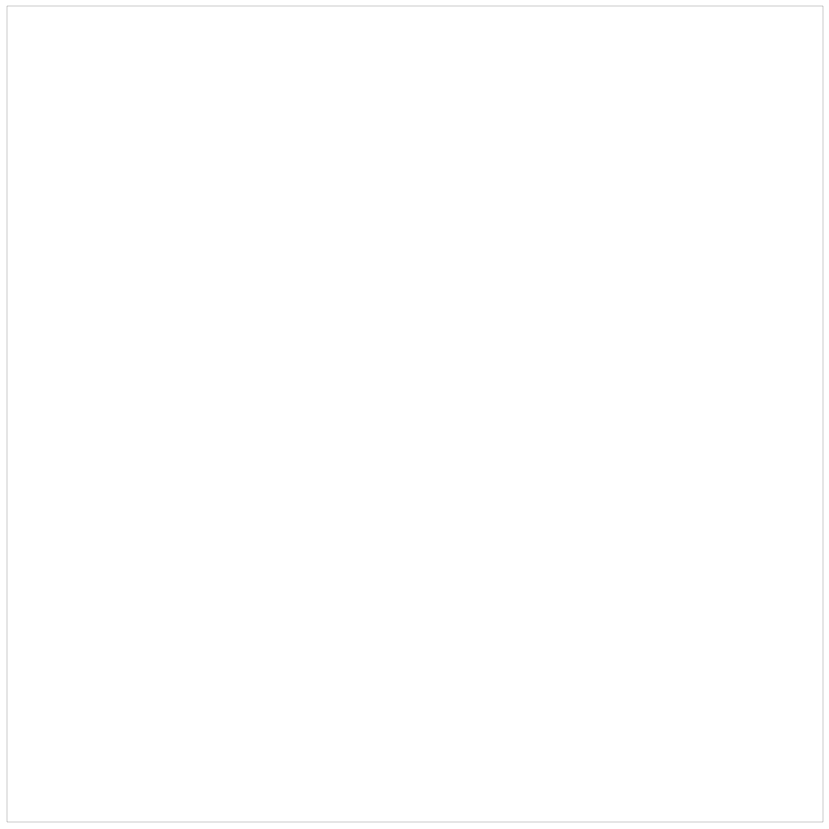

In [20]:
plt.rcParams['figure.figsize'] = [20, 15]

import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt    

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([170, 190, -50, -30], crs=ccrs.PlateCarree())
plt.scatter(temp_sat_df["Longitude"] + 180, temp_sat_df["Latitude"], c=temp_sat_df["Chlorophyll"], vmin=0, vmax=1, s=200)

plt.plot(compiled_df[compiled_df["Src"] == "FT"]["Long"] - 180, 
         compiled_df[compiled_df["Src"] == "FT"]["Lat"], 
         linewidth=5, color="black")

plt.plot(compiled_df[compiled_df["Src"] == "BGC"]["Long"] - 180, 
         compiled_df[compiled_df["Src"] == "BGC"]["Lat"],
         linewidth=5, color="grey")

plt.legend(["FT", "BGC"])

# add some features to make the map a little more polished
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines('50m')

plt.colorbar()

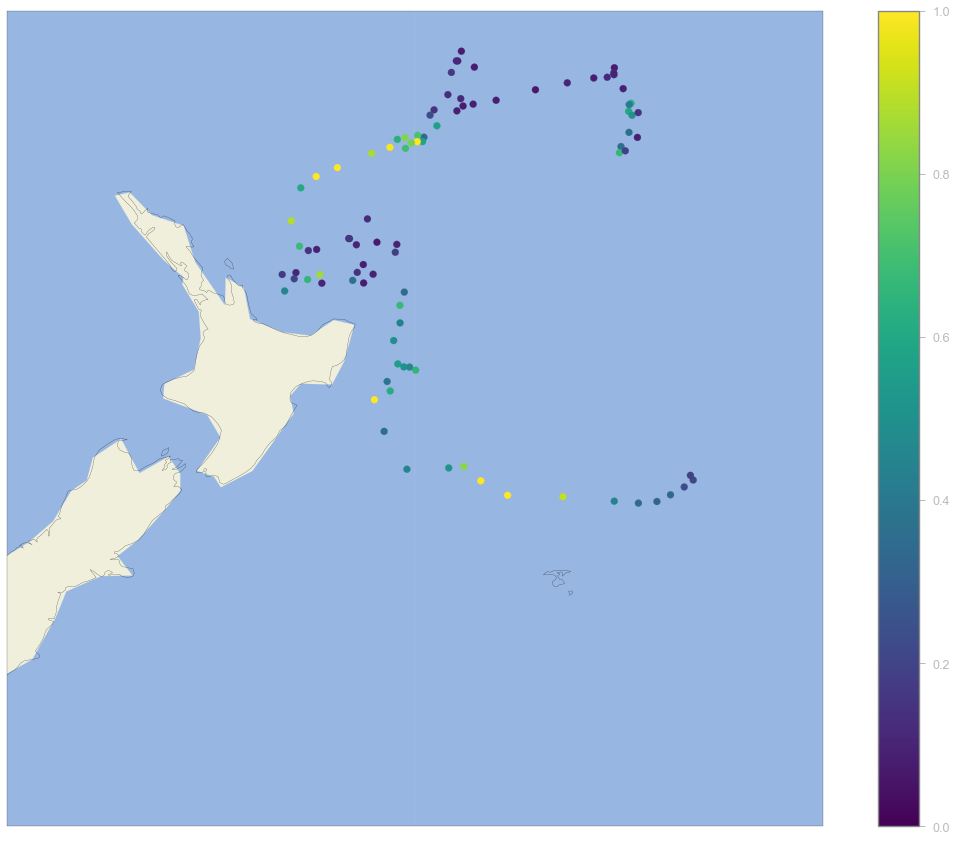

In [24]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([170, 190, -50, -30], crs=ccrs.PlateCarree())

# plt.scatter(compiled_df[compiled_df["Src"] == "FT"]["Long"] + 180, 
#             compiled_df[compiled_df["Src"] == "FT"]["Lat"], 
#             c=compiled_df[compiled_df["Src"] == "FT"]["Chl-A"], 
#             alpha=1, vmin=0, vmax=1)

plt.scatter(compiled_df[compiled_df["Src"] == "BGC"]["Long"] + 180, 
            compiled_df[compiled_df["Src"] == "BGC"]["Lat"], 
            c=compiled_df[compiled_df["Src"] == "BGC"]["Chl-A"], 
            alpha=1, vmin=0, vmax=1)

# add some features to make the map a little more polished
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines('50m')
# plt.legend(["FT", "BGC"])

plt.colorbar()

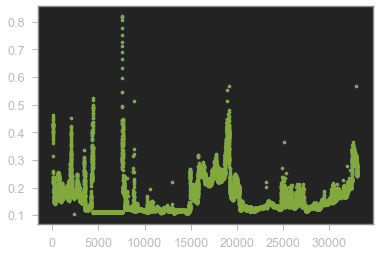

In [91]:
plt.plot(compiled_df[compiled_df["Src"] == "FT"]["Chl-A"], '.')
plt.plot(compiled_df[compiled_df["Src"] == "FT"]["Chl-A"], '.')

# Sandbox

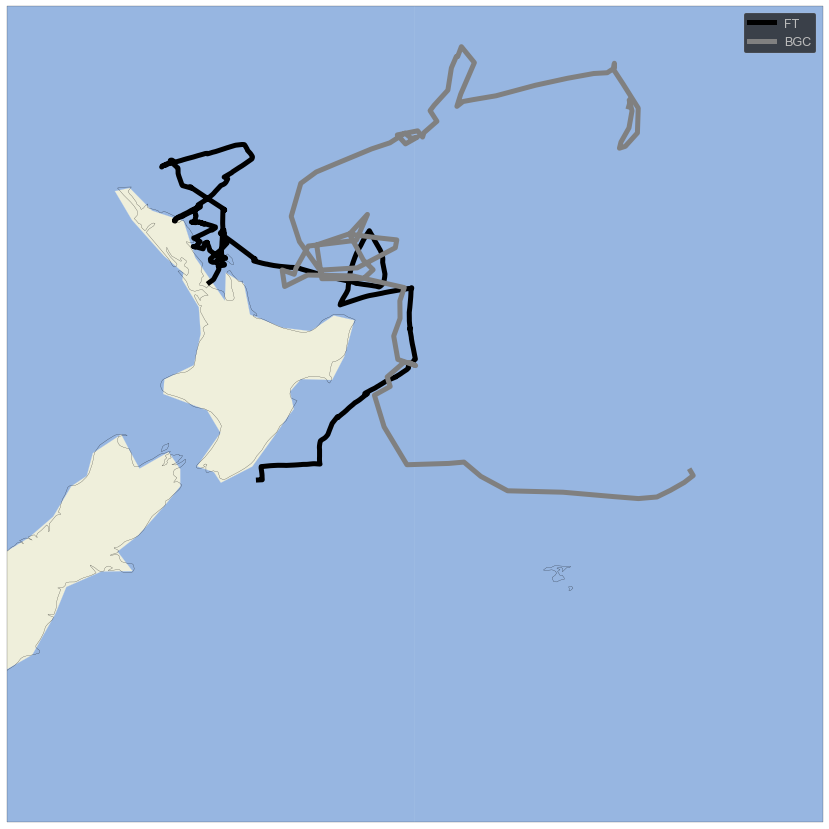

In [168]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([170, 190, -50, -30], crs=ccrs.PlateCarree())
# plt.scatter(compiled_df["Long"] + 180, compiled_df["Lat"], c=compiled_df["Chl-A"], 
#              alpha=0.5, vmin=0, vmax=1)
plt.plot(compiled_df[compiled_df["Src"] == "FT"]["Long"] - 180, 
         compiled_df[compiled_df["Src"] == "FT"]["Lat"], 
         linewidth=5, color="black")

plt.plot(compiled_df[compiled_df["Src"] == "BGC"]["Long"] - 180, 
         compiled_df[compiled_df["Src"] == "BGC"]["Lat"],
         linewidth=5, color="grey")

# add some features to make the map a little more polished
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines('50m')
plt.legend(["FT", "BGC"])

# plt.colorbar()

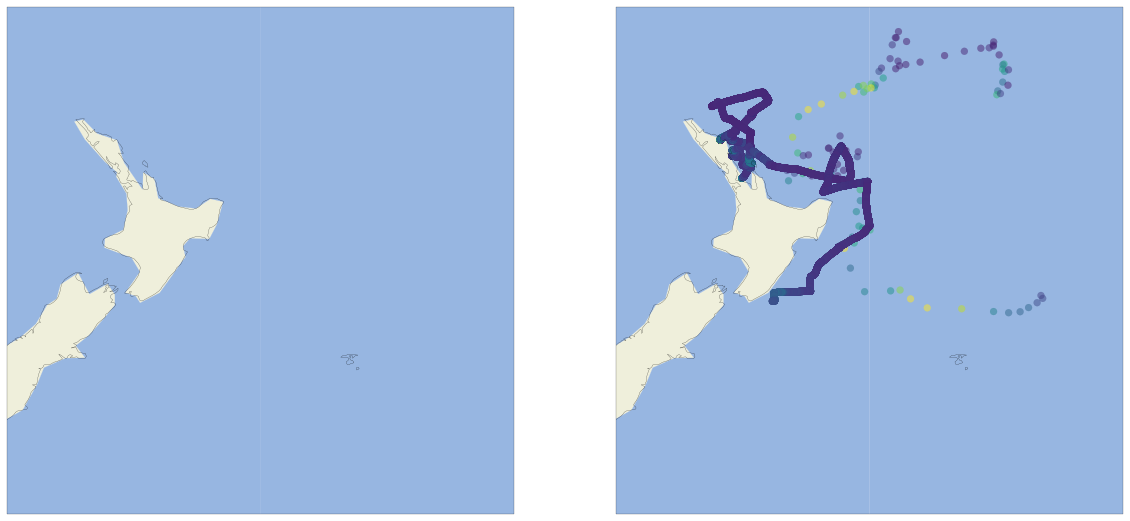

In [135]:
fig1, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
# ax1 = fig1.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_extent([170, 190, -50, -30], crs=ccrs.PlateCarree())

ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.OCEAN)
ax1.coastlines('50m')

# ax1.scatter(temp_sat_df["Longitude"] + 180, temp_sat_df["Latitude"], c=temp_sat_df["Chlorophyll"], vmin=0, vmax=5, alpha=0.5)

# ax2 = fig1.add_subplot(2, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax2.set_extent([170, 190, -50, -30], crs=ccrs.PlateCarree())

ax2.add_feature(cartopy.feature.LAND)
ax2.add_feature(cartopy.feature.OCEAN)
ax2.coastlines('50m')
ax2.scatter(compiled_df["Long"] + 180, compiled_df["Lat"], c=compiled_df["Chl-A"], 
             alpha=0.5, vmin=0, vmax=1)

# fig1.colorbar()
# ax1.xlim([-25, 17])
# ax1.ylim([-35, -30])
# ax1.axis("equal")
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# fig1.show()

In [34]:
# # from mpl_toolkits.basemap import Basemap
# # import matplotlib.pyplot as plt
# # # setup Lambert Conformal basemap.
# # m = Basemap(width=12000000,height=9000000,projection='lcc',
# #             resolution='c',lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# # # draw coastlines.
# # m.drawcoastlines()
# # # draw a boundary around the map, fill the background.
# # # this background will end up being the ocean color, since
# # # the continents will be drawn on top.
# # m.drawmapboundary(fill_color='aqua')
# # # fill continents, set lake color same as ocean color.
# # m.fillcontinents(color='coral',lake_color='aqua')
# # plt.show()

# import os
# os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"; #fixr
# from mpl_toolkits.basemap import Basemap

In [7]:
# import os
# import conda

# conda_file_dir = conda.__file__
# conda_dir = conda_file_dir.split('lib')[0]
# proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
# os.environ["PROJ_LIB"] = proj_lib

# from mpl_toolkits.basemap import Basemap

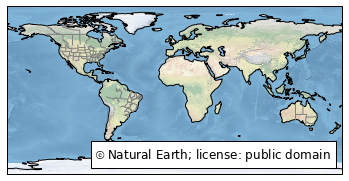

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText


def main():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
#     ax.set_extent([180, 150, -60, -5], crs=ccrs.PlateCarree())

    # Put a background image on for nice sea rendering.
    ax.stock_img()

    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(states_provinces, edgecolor='gray')

    # Add a text annotation for the license information to the
    # the bottom right corner.
    text = AnchoredText(r'$\mathcircled{{c}}$ {}; license: {}'
                        ''.format(SOURCE, LICENSE),
                        loc=4, prop={'size': 12}, frameon=True)
    ax.add_artist(text)

    plt.show()


if __name__ == '__main__':
    main()

In [13]:
import matplotlib.pyplot

ImportError: cannot import name 'VERSION'

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# ax.scatter(compiled_df["Long"], compiled_df["Lat"], c=compiled_df["Chl-A"], 
#             alpha=0.5, vmin=0, vmax=1)

ax.stock_img()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')

# Add a text annotation for the license information to the
# the bottom right corner.
text = AnchoredText(r'$\mathcircled{{c}}$ {}; license: {}'
                    ''.format(SOURCE, LICENSE),
                    loc=4, prop={'size': 12}, frameon=True)
ax.add_artist(text)

plt.show()

# plt.axis("equal")
# plt.colorbar()


In [189]:
a = pd.DataFrame({"a": [1,2,3,4], "b":[3,5,5,2]})

In [190]:
a

,a,b
0,1,3
1,2,5
2,3,5
3,4,2


In [191]:
a.iloc[0]

a    1
b    3
Name: 0, dtype: int64

In [192]:
type(a.iloc[0])

pandas.core.series.Series

In [ ]:
import timeit
start_time = timeit.default_timer()
# code you want to evaluate
for i in range(0,100):
    i + 5
elapsed = timeit.default_timer() - start_time
print(elapsed)